# Regresión

In [1]:
import torch
import matplotlib.pyplot as plt

## Aprendiendo a optimizar un modelo lineal

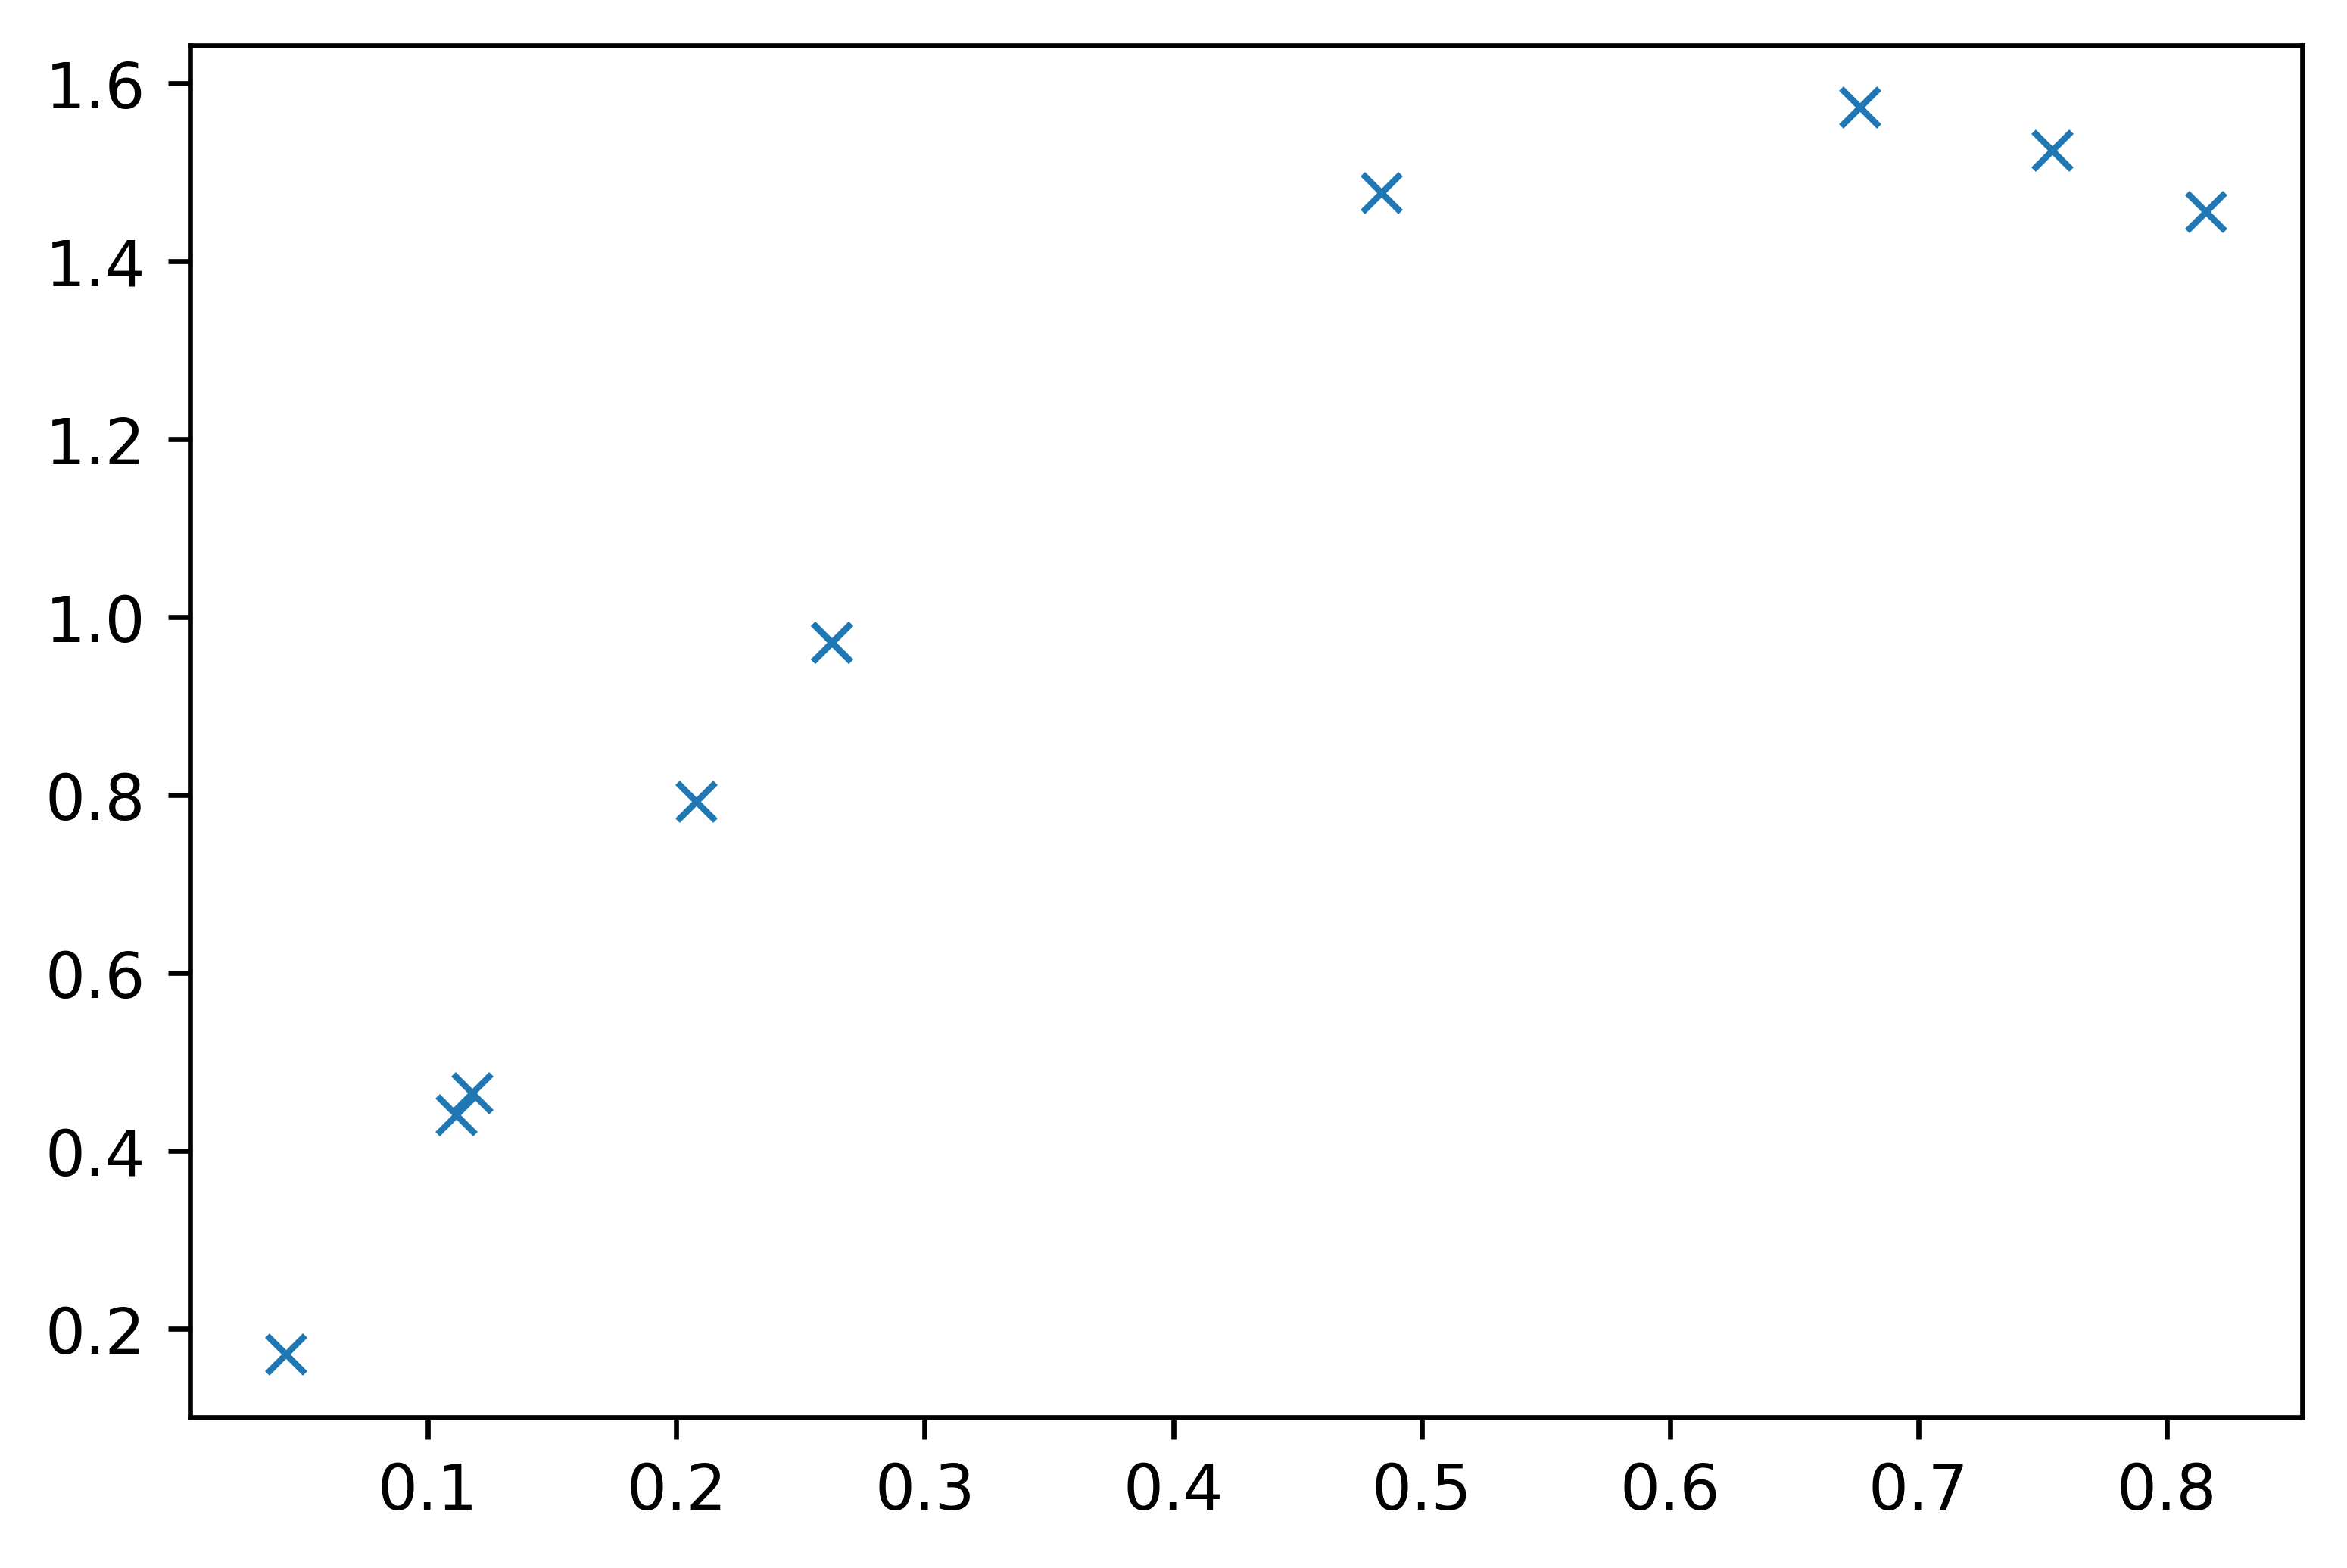

In [2]:
torch.random.manual_seed(100) # Seleccionamos una semilla para que sea reproducible
x = torch.rand(10) # Elementos aleatorios (uniforme) en [0, 1)
y = torch.sin(3*x) + x
plt.figure(dpi=600)
plt.plot(x, y, 'x')
plt.show()

In [3]:
def model(x, w, b):
    return w * x + b

def loss_fn(y_real, y_pred):
    squared_diffs = (y_real - y_pred)**2
    return squared_diffs.mean()

In [4]:
w = torch.rand(1)
b = torch.rand(1)

y_pred = model(x, w, b)
y_pred

tensor([0.7492, 0.8349, 0.7676, 0.7945, 0.8179, 0.8273, 0.7676, 0.7408, 0.7609,
        0.7500])

In [5]:
loss = loss_fn(y, y_pred)
loss

tensor(0.2493)

Lo que queremos es obtener los parámetros w y b óptimos para nuestro modelo. Esto se consigue minimizando la pérdida respecto a los parámetros (esto se llama backpropagation). Obtenemos las derivadas (gradiente) respecto a los parámetros, y actualizamos los parámetros dando un paso en el gradiente (esto se llama gradiente descendente).

In [6]:
def dloss_fn(y_real, y_pred):
    dsq_diffs = 2 * (y_pred - y_real) / y.size(0)
    return dsq_diffs

def dmodel_dw(x, w, b):
    return x

def dmodel_db(x, w, b):
    return 1.0

def grad_fn(y, y_pred, x, w, b):
    dloss_dy = dloss_fn(y, y_pred)
    dloss_dw = dloss_dy * dmodel_dw(x, w, b)
    dloss_db = dloss_dy * dmodel_db(x, w, b)
    # print(dloss_dw, dloss_db)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])  

Hay que tener en cuenta la normalización de los datos. Si los datos no estuvieran normalizados el gradiente afectaría distinto a cada parámetro provocando inestabilidades. Para solventar esto, es deseable que los datos de entrada para nuestro modelo esté entre -1 y 1.

In [7]:
def training_loop(n_epochs, learning_rate, params, x, y):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        y_pred = model(x, w, b)  # <1>
        loss = loss_fn(y, y_pred)
        grad = grad_fn(y, y_pred, x, w, b)  # <2>
        
        # print(grad)

        params = params - learning_rate * grad
        
        if epoch % 10 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss))) # <3>
            
    return params

In [8]:
params = training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    x = x, 
    y = y)

Epoch 10, Loss 0.304630
Epoch 20, Loss 0.208785
Epoch 30, Loss 0.148458
Epoch 40, Loss 0.110445
Epoch 50, Loss 0.086449
Epoch 60, Loss 0.071262
Epoch 70, Loss 0.061610
Epoch 80, Loss 0.055437
Epoch 90, Loss 0.051453
Epoch 100, Loss 0.048847


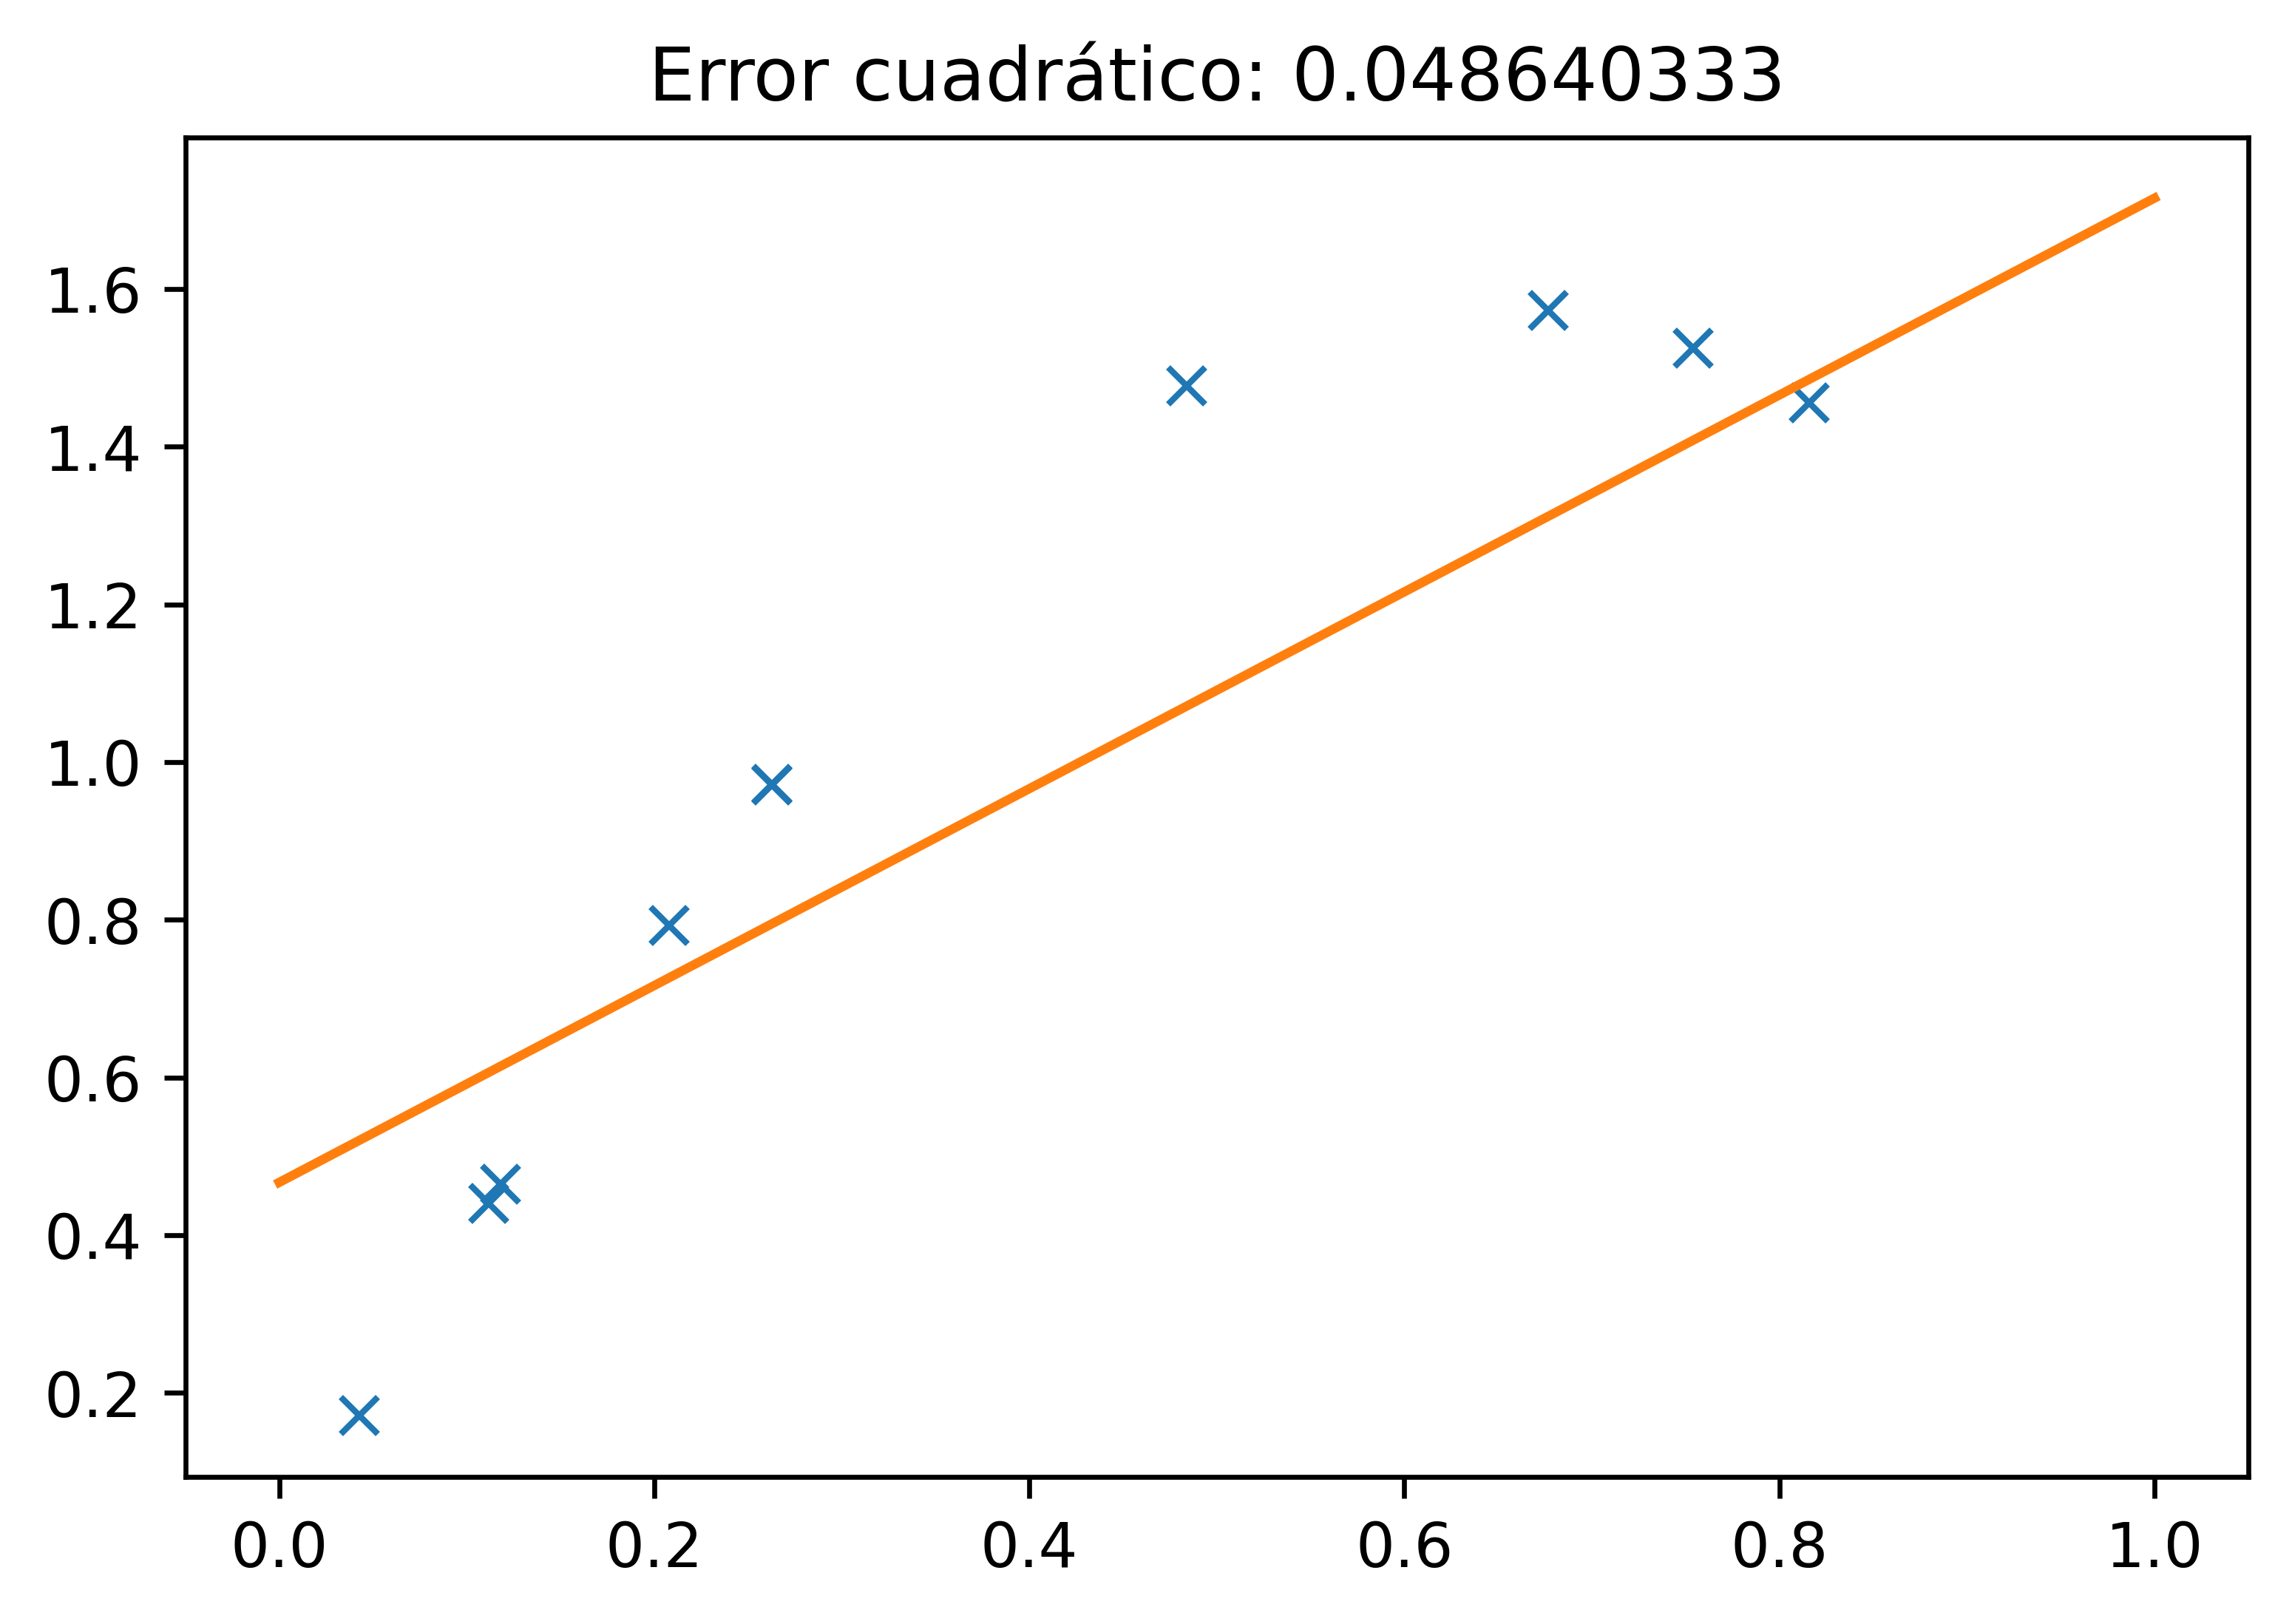

In [9]:
x_grid = torch.linspace(0, 1, 100)
y_pred_grid = model(x_grid, *params)
y_pred = model(x, *params)  # <1>
loss = loss_fn(y, y_pred)
plt.figure(dpi = 600)
plt.plot(x, y, 'x')
plt.plot(x_grid, y_pred_grid)
plt.title("Error cuadrático: " + str(loss.numpy()))
plt.show()

**Ejercicio:** Reproduce el ejemplo anterior usando un modelo cuadrático: $$f(x) = w_1 x² + w_0 x + b$$
¿Mejora los resultados?

## Autograd: Pytorch nos calcula las derivadas por nosotros!

El verdadero potencial de Pytorch está en el autograd. Pytorch es capaz de calcular el gradiente (las derivadas) de forma automática. De esta forma, el aprendizaje de modelos (y como veremos posteriormente de redes neuronales) es muy directa y automática. Sin embargo, siempre es importante entender qué hacemos y por qué lo hacemos.

In [10]:
params = torch.tensor([1.0, 0.0], requires_grad = True)
params.grad is None

True

In [11]:
loss = loss_fn(y, model(x, *params))
loss.backward()

params.grad

tensor([-0.5534, -1.2211])

In [12]:
dw = 2 * torch.mean(x * (model(x, *params) - y)) # w derivative
db = 2 * torch.mean(model(x, *params) - y) # b derivative

print(dw, db)

tensor(-0.5534, grad_fn=<MulBackward0>) tensor(-1.2211, grad_fn=<MulBackward0>)


Además Pytorch tiene distintos optimizadores, que dado el gradiente nos actualiza directamente los parámetros. El que hemos visto anteriormente sería similar al SGD (Gradiente descendente estocástico).

In [13]:
import os
import torch.optim as optim

In [14]:
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [15]:
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

In [16]:
loss = loss_fn(y, model(x, *params))
optimizer.zero_grad()
loss.backward()
optimizer.step()

params

tensor([1.0000e+00, 1.2211e-05], requires_grad=True)

In [17]:
def training_loop(n_epochs, optimizer, params, x, y):
    for epoch in range(1, n_epochs + 1):
        y_pred = model(x, *params) # <1>
        loss = loss_fn(y, y_pred)
        
        optimizer.zero_grad()
        loss.backward() # <2>
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, loss {loss.item():.4f}")
            
    return params

In [18]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    params = params,
    x = x, # <1> 
    y = y)

Epoch 1, loss 0.4384
Epoch 2, loss 0.4206
Epoch 3, loss 0.4037
Epoch 500, loss 0.0377
Epoch 1000, loss 0.0348
Epoch 1500, loss 0.0340
Epoch 2000, loss 0.0338
Epoch 2500, loss 0.0337
Epoch 3000, loss 0.0337


tensor([1.6478, 0.3688], requires_grad=True)

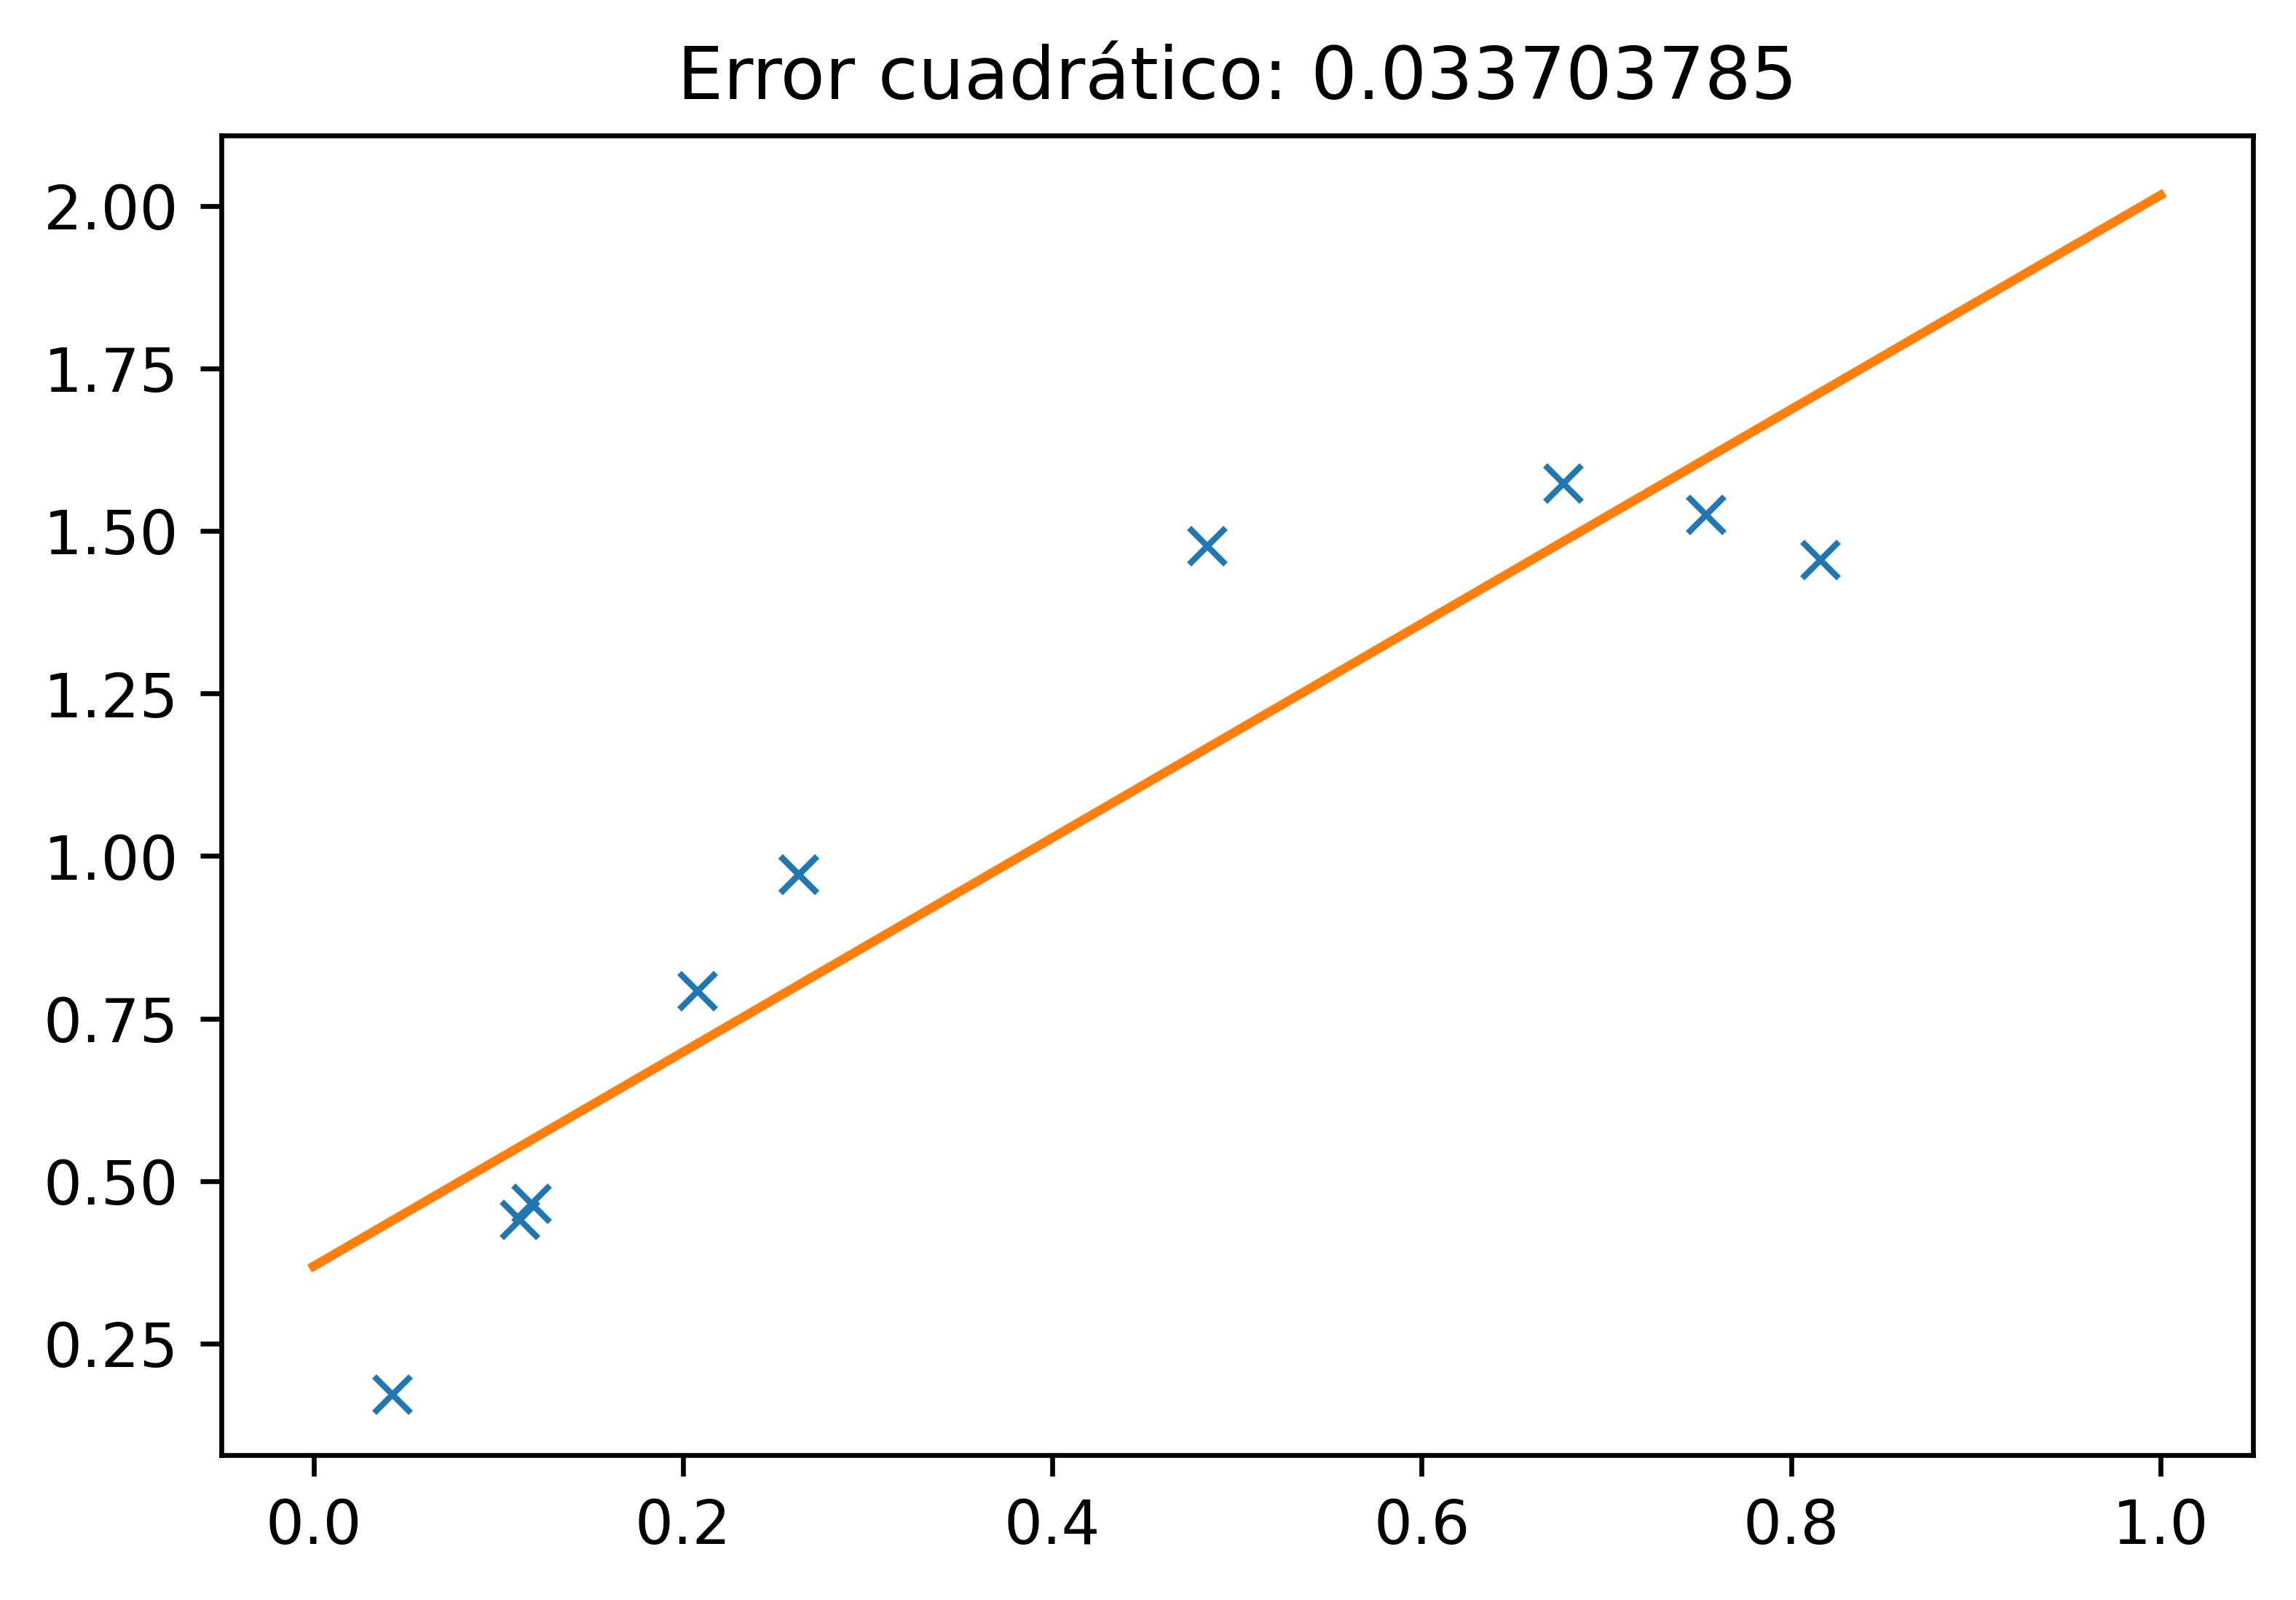

In [19]:
x_grid = torch.linspace(0, 1, 100)
y_pred_grid = model(x_grid, *params)
y_pred = model(x, *params)  # <1>
loss = loss_fn(y, y_pred)
plt.figure(dpi = 600)
plt.plot(x, y, 'x')
plt.plot(x_grid, y_pred_grid.detach()) # Tenemos que extraer la variable del grafo de Pytorch
plt.title("Error cuadrático: " + str(loss.detach().numpy()))
plt.show()

## Mi primera red neuronal

In [20]:
import torch.nn as nn

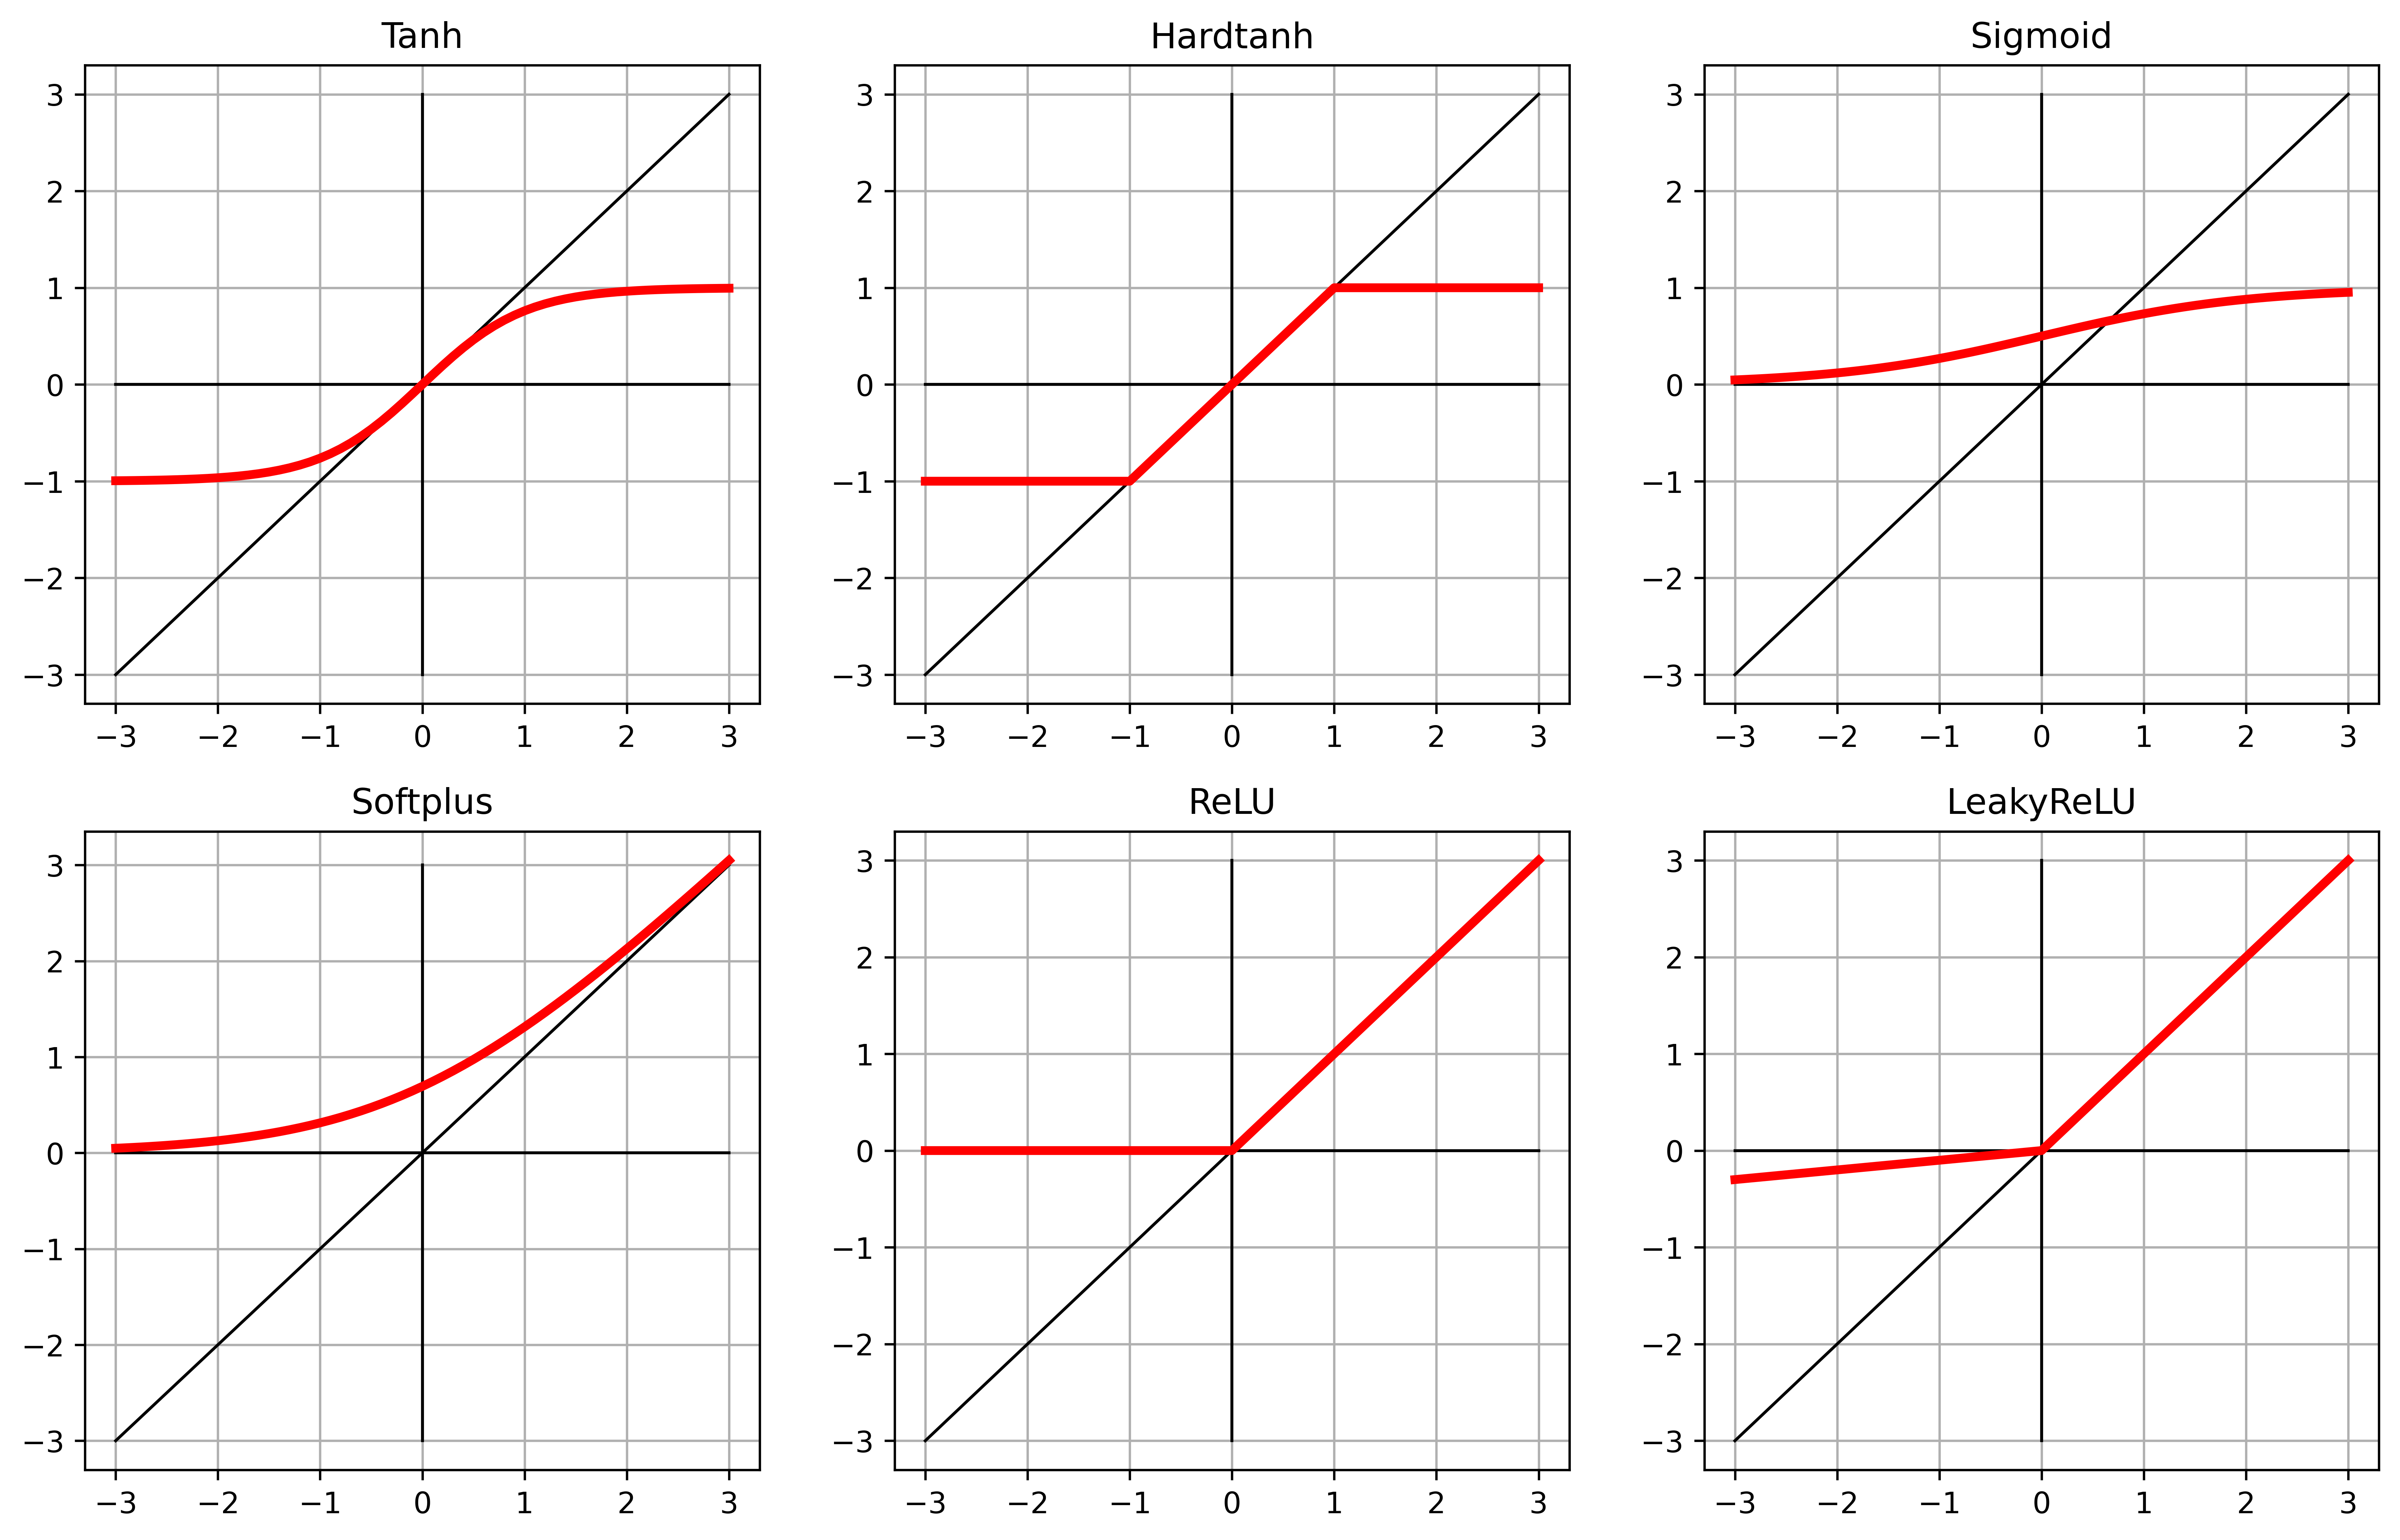

In [21]:
input_t = torch.arange(-3, 3.1, 0.1)

activation_list = [
    nn.Tanh(),
    nn.Hardtanh(),
    nn.Sigmoid(),
    
    nn.Softplus(),
    nn.ReLU(),
    nn.LeakyReLU(negative_slope=0.1),

    
    #nn.Tanhshrink(),
    #nn.Softshrink(),
    #nn.Hardshrink(),
]

fig = plt.figure(figsize=(14, 28), dpi=600)

for i, activation_func in enumerate(activation_list):
    subplot = fig.add_subplot(len(activation_list), 3, i+1)
    subplot.set_title(type(activation_func).__name__)
    
    output_t = activation_func(input_t)
    
    plt.grid()
    plt.plot(input_t.numpy(), input_t.numpy(),'k', linewidth=1)
    plt.plot([-3,3], [0,0], 'k', linewidth=1)
    plt.plot([0,0], [-3,3], 'k', linewidth=1)
    plt.plot(input_t.numpy(), output_t.numpy(), 'r', linewidth=3)

plt.show()

Una red neuronal es una composición de funciones.

In [30]:
from ipywidgets import interact

@interact(w=(-3,3, 0.1), b=(-2,2, 0.5))
def composition(w, b):
    linear = w * input_t + b
    activation = nn.Tanh()(linear)

    fig = plt.figure(dpi=600)

    for i, activation_func in enumerate(activation_list):

        plt.grid()
        plt.ylim(-3, 3)
        plt.xlim(-3, 3)
        plt.plot(input_t.numpy(), input_t.numpy(),'k', linewidth=0.5)
        plt.plot([-3,3], [0,0], 'k', linewidth=0.5)
        plt.plot([0,0], [-3,3], 'k', linewidth=0.5)
        plt.plot(input_t.numpy(), linear.numpy(), 'g', linewidth=1)
        plt.plot(input_t.numpy(), nn.Tanh()(input_t).numpy(), 'b', linewidth=1)
        plt.plot(input_t.numpy(), activation.numpy(), 'r', linewidth=3)
        plt.title(f"Tanh({w:.2f}x+{b})")

    plt.show()

interactive(children=(FloatSlider(value=0.0, description='w', max=3.0, min=-3.0), FloatSlider(value=0.0, descr…

In [23]:
from ipywidgets import interact